# import libraries

In [1]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip '/content/drive/MyDrive/NSU/Fake_med/archive (1) 2.zip'

Archive:  /content/drive/MyDrive/NSU/Fake_med/archive (1) 2.zip
   creating: archive (1)/
  inflating: __MACOSX/._archive (1)  
  inflating: archive (1)/.DS_Store   
  inflating: __MACOSX/archive (1)/._.DS_Store  
   creating: archive (1)/Real/
  inflating: __MACOSX/archive (1)/._Real  
   creating: archive (1)/Fake/
  inflating: __MACOSX/archive (1)/._Fake  
  inflating: archive (1)/Real/DALLE 2022-09-30 15.07.08 - lung ct image.png  
  inflating: __MACOSX/archive (1)/Real/._DALLE 2022-09-30 15.07.08 - lung ct image.png  
  inflating: archive (1)/Real/DALLE 2022-09-28 20.05.25 - lungs CT image.png  
  inflating: __MACOSX/archive (1)/Real/._DALLE 2022-09-28 20.05.25 - lungs CT image.png  
  inflating: archive (1)/Real/DALLE 2022-09-30 14.58.17 - lung CT image.png  
  inflating: __MACOSX/archive (1)/Real/._DALLE 2022-09-30 14.58.17 - lung CT image.png  
  inflating: archive (1)/Real/DALLE 2022-09-30 14.52.17 - lung CT image.png  
  inflating: __MACOSX/archive (1)/Real/._DALLE 2022-09-30

In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/NSU/Fake_med/Dataset1', output="splitted_data", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 4200 files [01:41, 41.35 files/s] 


In [7]:
!zip -r '/content/splitted_data.zip' '/content/splitted_data'

!cp '/content/splitted_data.zip' -d '/content/drive/MyDrive/NSU/Fake_med'

  adding: content/splitted_data/ (stored 0%)
  adding: content/splitted_data/train/ (stored 0%)
  adding: content/splitted_data/train/Real/ (stored 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-109.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-268.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-572.png (deflated 1%)
  adding: content/splitted_data/train/Real/Tuberculosis-96.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-238.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-645.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-127.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-292.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-214.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-229.png (deflated 0%)
  adding: content/splitted_data/train/Real/Tuberculosis-84.png (defla

In [8]:
!cp '/content/drive/MyDrive/NSU/Fake_med/splitted_data.zip' -d '/content'
!unzip '/content/splitted_data.zip'

Archive:  /content/splitted_data.zip
   creating: content/splitted_data/
   creating: content/splitted_data/train/
   creating: content/splitted_data/train/Real/
  inflating: content/splitted_data/train/Real/Tuberculosis-109.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-268.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-572.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-96.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-238.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-645.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-127.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-292.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-214.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-229.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-84.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-417.png  
  inflating:

In [9]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocessing

#### we will split the data by the generator to train,test and validation.

In [10]:
image_gen = ImageDataGenerator()

In [11]:
train_generator = image_gen.flow_from_directory('/content/splitted_data/train',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 2939 images belonging to 2 classes.


In [12]:
valid_generator = image_gen.flow_from_directory('/content/splitted_data/val',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 840 images belonging to 2 classes.


In [13]:
test_generator = image_gen.flow_from_directory('/content/splitted_data/test',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 421 images belonging to 2 classes.


# Modeling

### Classify The Model

In [14]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )

In [15]:
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

In [16]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7031232   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [50]:
history = model.fit(
    train_generator,
    steps_per_epoch = (2939//100),
    validation_data = valid_generator,
    validation_steps = (840//100),
    epochs = 10
)

Epoch 1/10
29/29 [==============================] - 48s 2s/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.9093 - val_accuracy: 0.8462
Epoch 2/10
29/29 [==============================] - 45s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9812
Epoch 3/10
29/29 [==============================] - 44s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9900
Epoch 4/10
29/29 [==============================] - 44s 1s/step - loss: 0.0040 - accuracy: 0.9982 - val_loss: 2.8187 - val_accuracy: 0.4625
Epoch 5/10
29/29 [==============================] - 44s 2s/step - loss: 0.0129 - accuracy: 0.9954 - val_loss: 15.8303 - val_accuracy: 0.1737
Epoch 6/10
29/29 [==============================] - 45s 2s/step - loss: 0.0094 - accuracy: 0.9961 - val_loss: 9.4673 - val_accuracy: 0.1688
Epoch 7/10
29/29 [==============================] - 42s 1s/step - loss: 0.0290 - accuracy: 0.9887 - val_loss: 32.9815 - val_accuracy: 0.3100
Epoch 8/10
29/29 [

In [51]:
model.save('medical_fake.h5')

In [ ]:
#load_model('./Real VS Fake.h5')

### Model evaluation

In [52]:
losses = pd.DataFrame(model.history.history)

<Axes: >

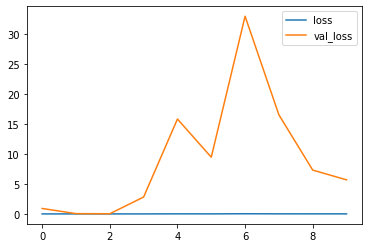

In [53]:
losses[['loss','val_loss']].plot()

<Axes: >

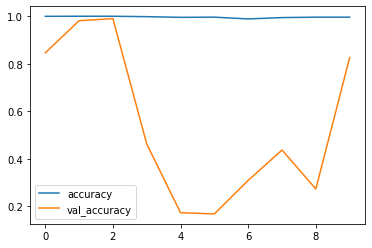

In [54]:
losses[['accuracy','val_accuracy']].plot()

### prediction

In [55]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

421/421 [==============================] - 10s 23ms/step


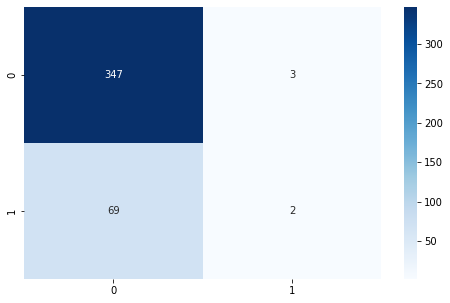

In [56]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [57]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.3642655935613682
AP Score: 0.15220874135868925


In [58]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91       350
           1       0.40      0.03      0.05        71

    accuracy                           0.83       421
   macro avg       0.62      0.51      0.48       421
weighted avg       0.76      0.83      0.76       421

